<a href="https://colab.research.google.com/github/mako-commits/Ontario-Energy-Demand/blob/main/Ontario_Energy_Demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from prophet import Prophet
from prophet.diagnostics import performance_metrics, cross_validation
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [ ]:
df = pd.read_csv('ontario_electricity_demand.csv')

In [ ]:
df.head()

,date,hour,hourly_demand,hourly_average_price
0,2002-05-01,1,14137000,22.97
1,2002-05-01,2,13872000,23.27
2,2002-05-01,3,13820000,24.54
3,2002-05-01,4,13744000,15.17
4,2002-05-01,5,14224000,23.59


In [ ]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index(df['date'] + pd.to_timedelta(df['hour'], unit='hour'))

In [ ]:
def create_features(df):
  df = df.copy()
  df['Hour'] = df.index.hour
  df['Day_of_Week'] = df.index.dayofweek
  df['Quarter'] = df.index.quarter
  df['Month'] = df.index.month
  df['Year'] = df.index.year
  df['Day_of_Year'] = df.index.dayofyear
  df['Day_of_Month'] = df.index.day
  df['Week_of_Year'] = df.index.isocalendar().week
  df['Month_Year'] =  df.date.dt.to_period("M").dt.to_timestamp()
  return df


In [ ]:
df = create_features(df)

In [ ]:
df.head()

,date,hour,hourly_demand,hourly_average_price,Hour,Day_of_Week,Quarter,Month,Year,Day_of_Year,Day_of_Month,Week_of_Year,Month_Year
2002-05-01 01:00:00,2002-05-01,1,14137000,22.97,1,2,2,5,2002,121,1,18,2002-05-01
2002-05-01 02:00:00,2002-05-01,2,13872000,23.27,2,2,2,5,2002,121,1,18,2002-05-01
2002-05-01 03:00:00,2002-05-01,3,13820000,24.54,3,2,2,5,2002,121,1,18,2002-05-01
2002-05-01 04:00:00,2002-05-01,4,13744000,15.17,4,2,2,5,2002,121,1,18,2002-05-01
2002-05-01 05:00:00,2002-05-01,5,14224000,23.59,5,2,2,5,2002,121,1,18,2002-05-01


In [ ]:
df.columns

Index(['date', 'hour', 'hourly_demand', 'hourly_average_price', 'Hour',
       'Day_of_Week', 'Quarter', 'Month', 'Year', 'Day_of_Year',
       'Day_of_Month', 'Week_of_Year', 'Month_Year'],
      dtype='object')

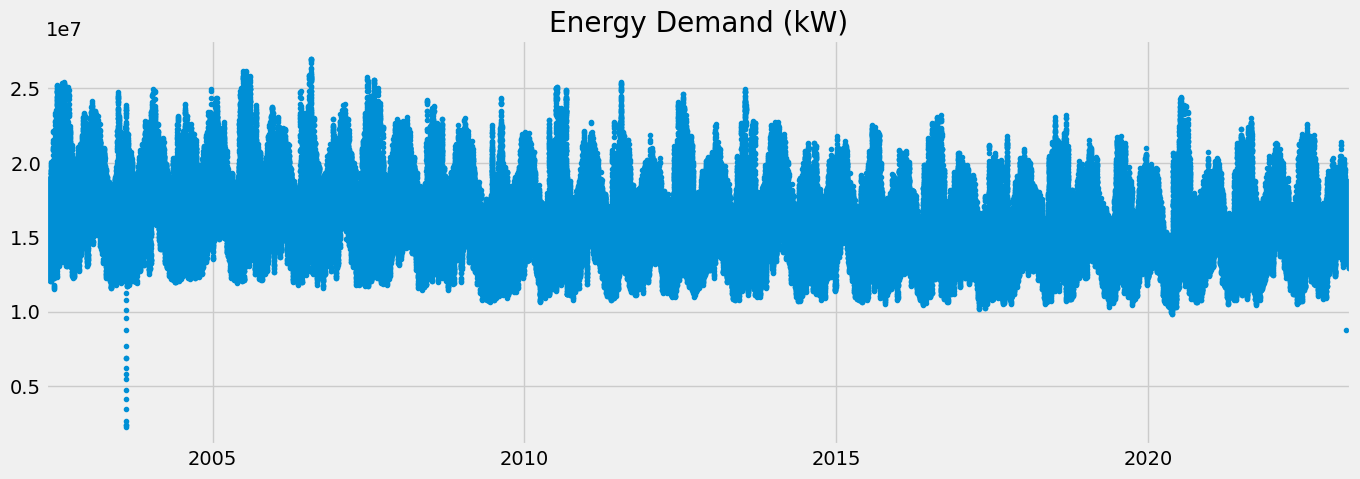

In [ ]:
df['hourly_demand'].plot(style='.', figsize=(15,5), color=color_pal[0], title='Energy Demand (kW)')
plt.show()

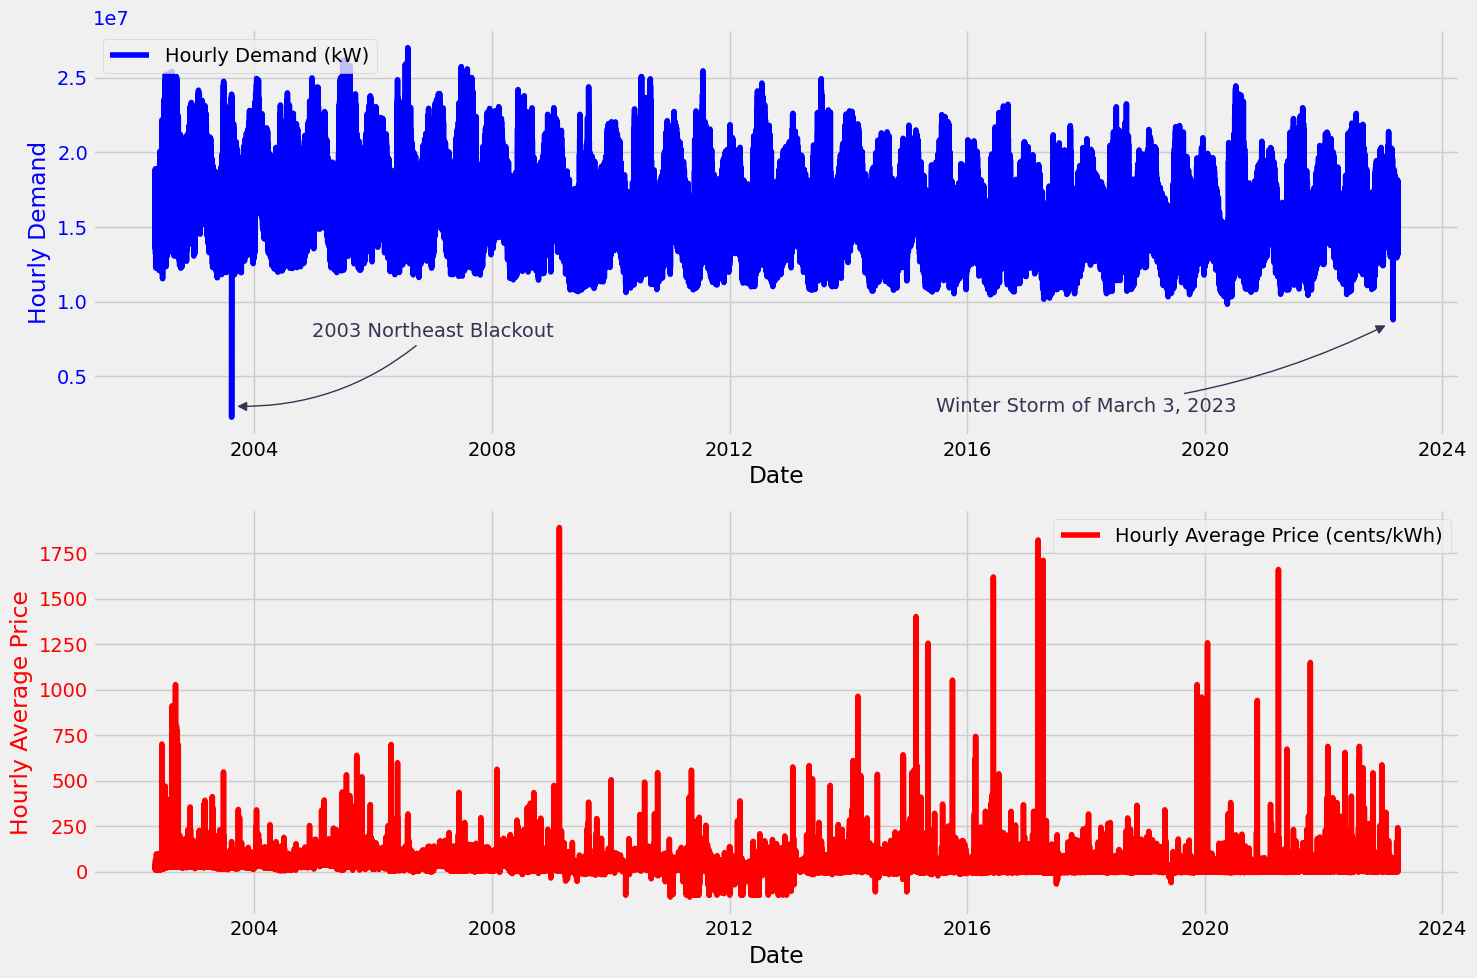

In [ ]:
# A figure and axis objects for two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Hourly Demand on the first subplot
ax1.plot(df.index, df['hourly_demand'], color='blue', label='Hourly Demand (kW)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Hourly Demand', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')


# Addressing Outliers in the dataset
ax1.annotate(xy = (pd.to_datetime('2003-09-01'),0.3e+7),  xytext=(pd.to_datetime('2007-01-01'),0.8e+7), text='2003 Northeast Blackout',
             color='#333652',
            va="center", ha="center", arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=-0.2", color='#333652', linewidth=1))

ax1.annotate(xy = (pd.to_datetime('2023-02-01'),0.85e+7),  xytext=(pd.to_datetime('2018-01-01'),0.3e+7), text='Winter Storm of March 3, 2023',
             color='#333652',
            va="center", ha="center", arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=0.1", color='#333652', linewidth=1))

# Hourly Average Price on the second subplot
ax2.plot(df.index, df['hourly_average_price'], color='red', label='Hourly Average Price (cents/kWh)')
ax2.set_xlabel('Date')
ax2.set_ylabel('Hourly Average Price', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


## Trends in the Dataset

In [ ]:
# Filter data for the year 2023
year_2023_data = df[df['Year'] == 2023]

# Filter data for peak winter and summer months (assuming winter months are December, January, February and summer months are June, July, August)
winter_months = [12, 1, 2]
summer_months = [6, 7, 8]
winter_data = year_2023_data[year_2023_data['Month'].isin(winter_months)]
summer_data = year_2023_data[year_2023_data['Month'].isin(summer_months)]



<ipython-input-294-c1413be36f9b>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Year', y='hourly_demand', palette="Blues")
<ipython-input-294-c1413be36f9b>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


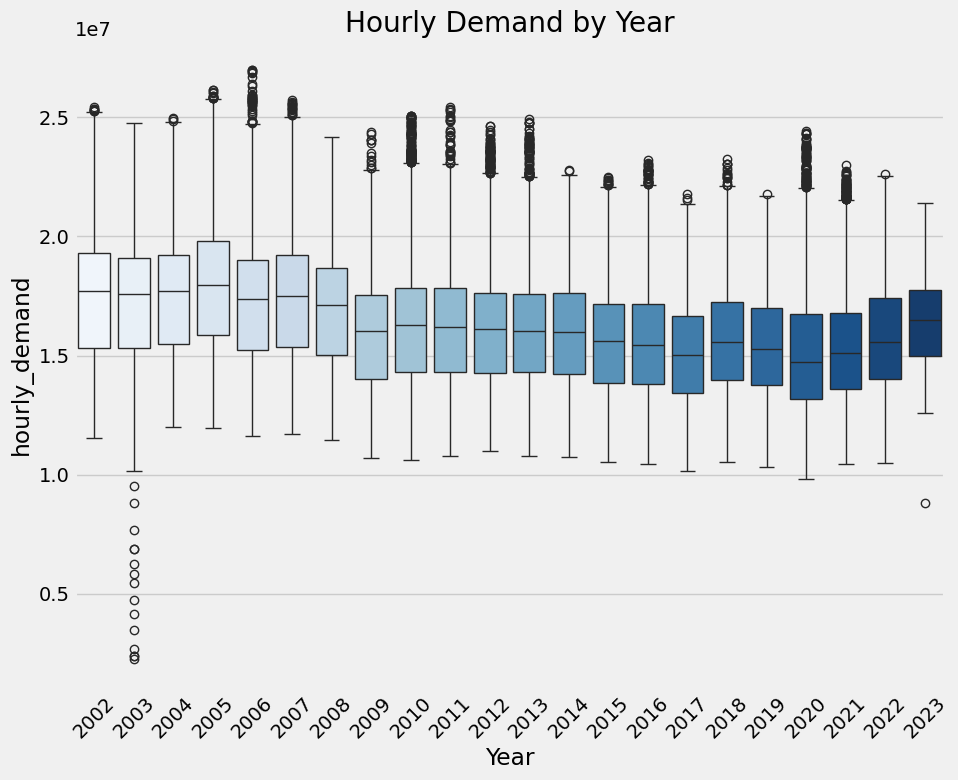

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='Year', y='hourly_demand', palette="Blues")
ax.set_title('Hourly Demand by Year')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

<ipython-input-295-411dbb5a84ec>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Month', y='hourly_demand',palette="Blues")


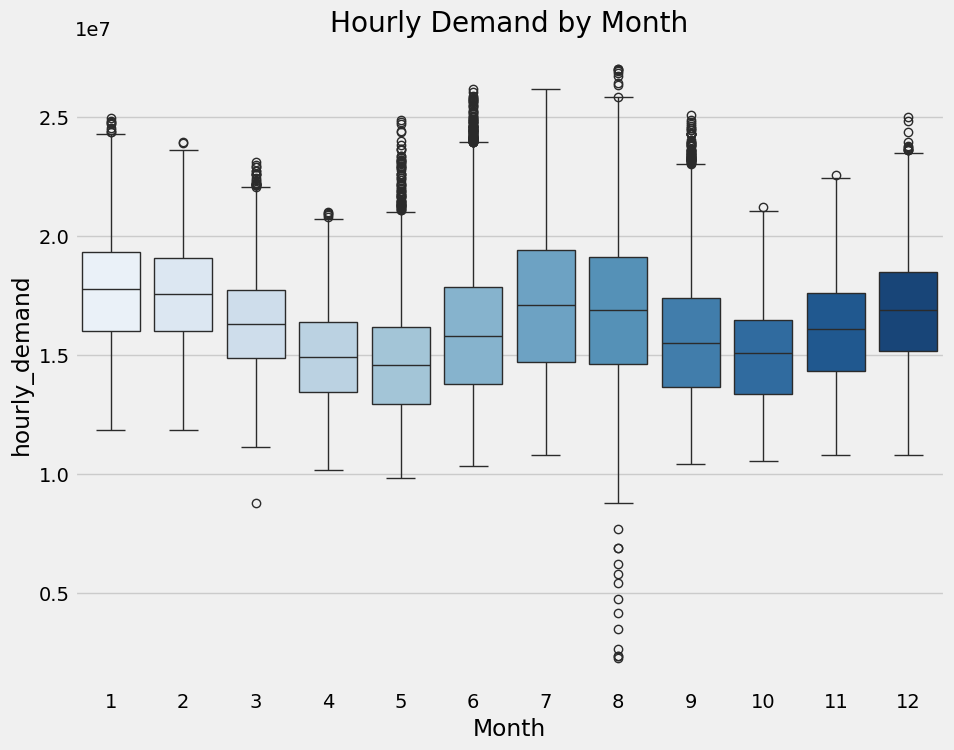

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='Month', y='hourly_demand',palette="Blues")
ax.set_title('Hourly Demand by Month')
plt.show()

<ipython-input-296-8022d0865421>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='hour', y='hourly_demand', palette="Blues")


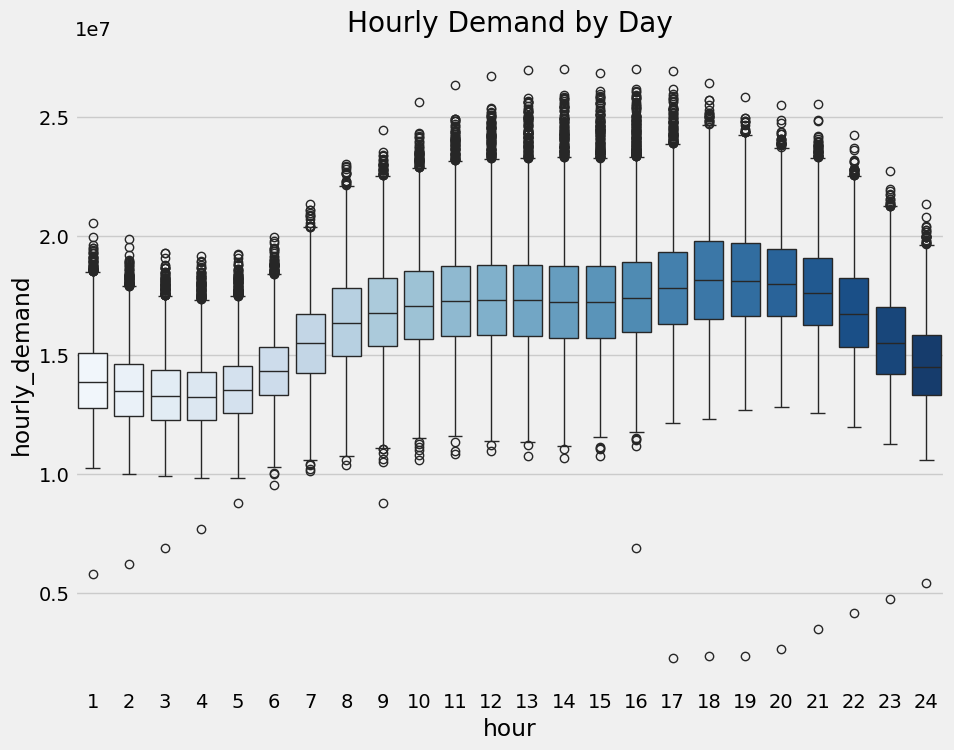

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='hourly_demand', palette="Blues")
ax.set_title('Hourly Demand by Day')
plt.show()

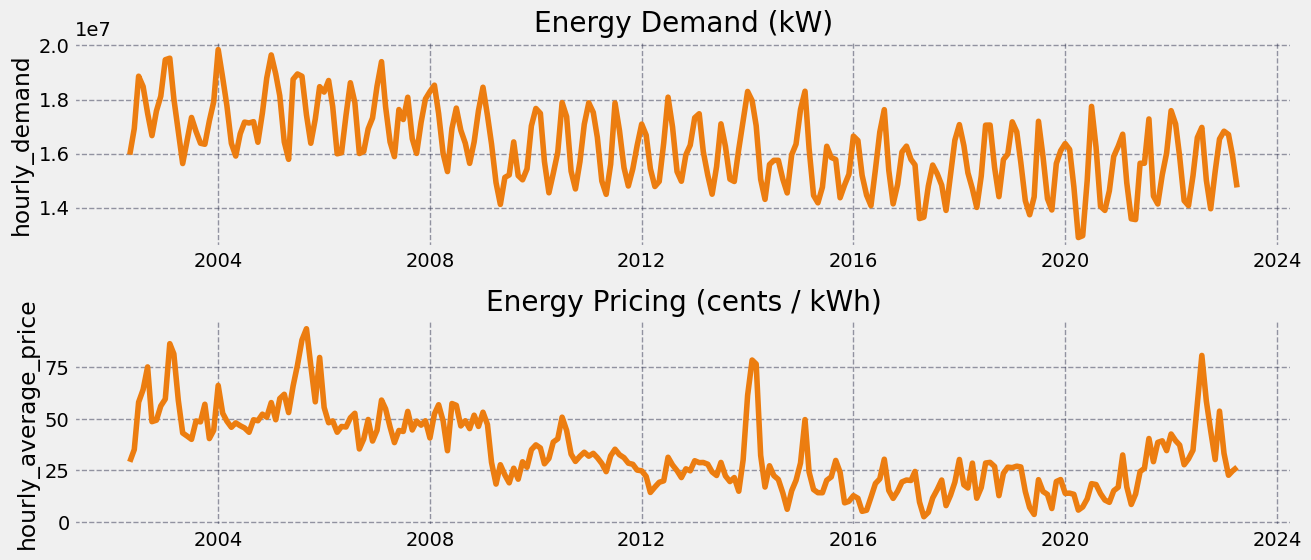

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6))
plt.subplots_adjust(hspace=0.35)

ax1 = sns.lineplot(data=df, x='Month_Year', y='hourly_demand', errorbar=None, color='#EC7D10', ax=ax1)
ax1.set_title('Energy Demand (kW)')

ax2 = sns.lineplot(data=df, x='Month_Year', y='hourly_average_price', color='#EC7D10', errorbar=None, ax=ax2)
ax2.set_title('Energy Pricing (cents / kWh)')

for ax in (ax1, ax2):
    ax.set_xlabel('')
    ax.grid(color='#333652', linestyle='--', alpha=0.5)
    ax.set_axisbelow(True)

## Train/Test Split

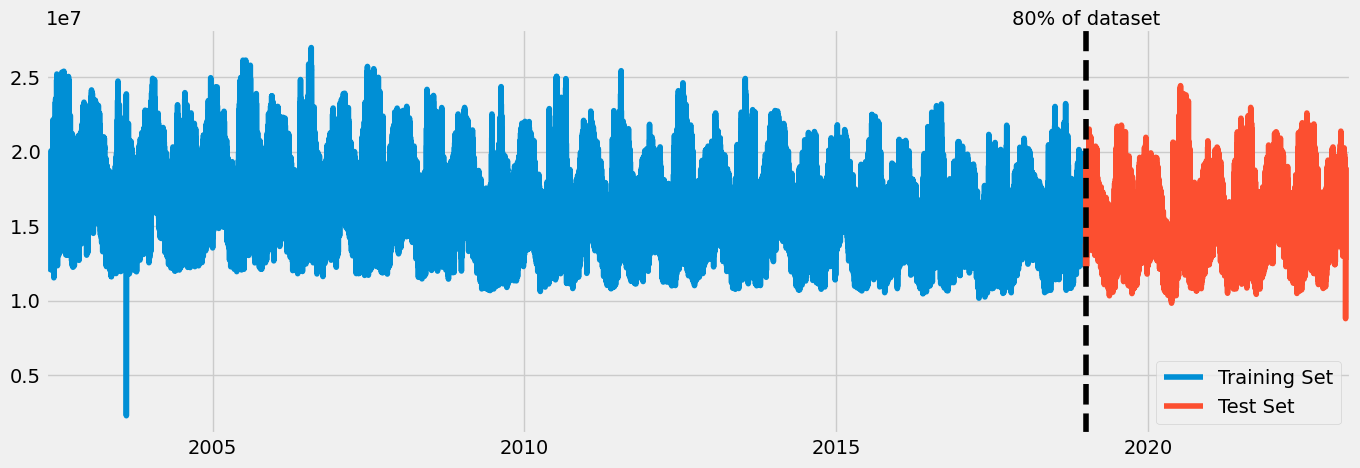

In [ ]:
# Subset DataFrame into training and test sets
train = df.loc[df.index < '2019-01-01']
test = df.loc[df.index >= '2019-01-01']

fig, ax = plt.subplots(figsize=(15, 5))
train['hourly_demand'].plot(ax=ax, label='Training Set')
test['hourly_demand'].plot(ax=ax, label='Test Set')
ax.axvline('2019-01-01', color='black', ls='--')
ax.text('2019-01-01', ax.get_ylim()[1], '80% of dataset', va='bottom', ha='center', color='black')

ax.legend()
plt.show()

## Model Creation

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbqjmtpou/_8zin8pb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbqjmtpou/pkqhdspj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64532', 'data', 'file=/tmp/tmpbqjmtpou/_8zin8pb.json', 'init=/tmp/tmpbqjmtpou/pkqhdspj.json', 'output', 'file=/tmp/tmpbqjmtpou/prophet_modelx338hwv8/prophet_model-20240507021918.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:19:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:21:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


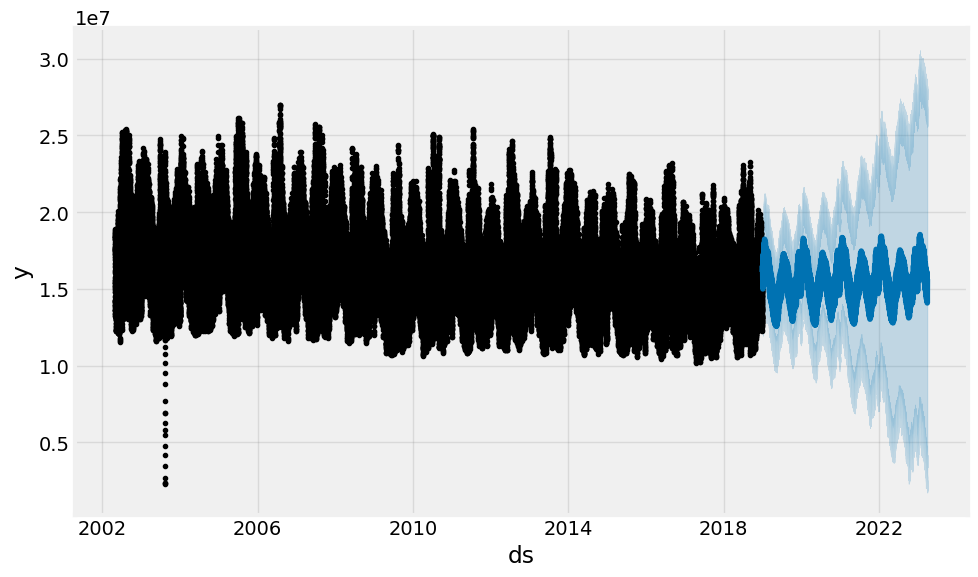

In [ ]:
# Prepare data for Prophet
train_prophet = train.rename(columns={'date': 'ds', 'hourly_demand': 'y'})
test_prophet = test.rename(columns={'date': 'ds', 'hourly_demand': 'y'})

# Instantiate Prophet model
model = Prophet()

# Fit the model to the training data
model.fit(train_prophet)

# Make predictions on the test data
#future = model.make_future_dataframe(periods=2190)
forecast = model.predict(test_prophet)

# Extract actual and predicted values from forecast
actual_values = test_prophet['y']
predicted_values = forecast['yhat'][-len(test):]

# Optionally, you can visualize the forecast
fig = model.plot(forecast)
plt.show()

In [ ]:
mape = mean_absolute_percentage_error(test_prophet['y'], forecast['yhat'])
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

Mean Absolute Percentage Error (MAPE): 10.72%
